# **国内期权市场粗糙波动率检验**

In [2]:
import warnings
warnings.simplefilter('ignore')
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
#from matplotlib.mlab import stineman_interp
import pandas as pd
import pandas_datareader.data as web
import requests
import zipfile as zi 
#from io import StringIO as sio
from io import BytesIO
from sklearn import datasets, linear_model
import scipy.special as scsp
from scipy.stats import norm
import statsmodels.api as sm
import math
import seaborn as sns
sns.set()
%matplotlib inline

-------------------------

## **Outline of presentation**
- The time series of historical volatility
    - Scaling properties
- The RFSV model
- Pricing under rough volatility
- Forecasting realized variance
- The time series of variance swaps
- Relating historical and implied

-------------------------

## **1.1 已实现波动率的时间序列**, 原文做法
- 假设标的方差过程 (variance process) $v_{s}$, 方差积分$\frac{1}{\delta} \int_{t}^{t+\delta} v_{s} d s$在有足够的价格数据的前提下原则上能够被任意精确地估计;
    - 原则上, 市场微观噪声使得高频估计变得困难
    - 有不同的方差积分估计方法来根据市场噪声进行调整, [Gatheral, Oomen];
- Oxford-Man Institute of Quantitative Finance在[http://realized.oxfordman.ox.ac.uk](http://realized.oxfordman.ox.ac.uk)提供了免费的已实现波动率估计数据;
    - 21个来自全球的指数(***目前该网站已无法连接***)
- 用日已实现波动率的估计作为瞬时波动率的代理, 我们可以经验地(empirically)研究 $v_{t}$ 的时间序列属性.

------------------------

## 1.2 **国内期权做法**

In [39]:
symbol_list = ['510050', '510300', '510500', '159915']
for csd_symbol in symbol_list:
    df = pd.read_hdf(r'C:\Users\dingwenjie\Desktop\demo\demo\dwj_tools\dwj_tools\get_dogsk_data\min_data.h5', key=csd_symbol)
    temp_df = df['close']  # 分钟未复权数据
    temp_df.index = pd.to_numeric(df['date'])
    fadj_data = pd.read_excel(r'C:\Users\dingwenjie\Desktop\demo\demo\dwj_tools\dwj_tools\get_dogsk_data\fadj_data.xlsx', sheet_name=csd_symbol, index_col=0)
    fadj_factor = fadj_data['adjfactor'].drop_duplicates()  # 复权因子
    date_list = np.array([int(a.strftime('%Y%m%d')) for a in fadj_factor.index])  # 复权因子变化的时间
    fadj_factor.index = date_list
    fadj_temp_df = []  # 复权后的分钟数据
    for i, min_close in enumerate(temp_df.values):
        temp_idd = np.sum((temp_df.index[i]>=date_list)!=0)
        fadj_temp_df += [min_close*fadj_factor.values[temp_idd-1]/fadj_factor.values[-1]]
    globals()[f'df_{csd_symbol}'] = pd.DataFrame()
    globals()[f'df_{csd_symbol}']['close'] = fadj_temp_df
    globals()[f'df_{csd_symbol}'].index = temp_df.index
    globals()[f'df_{csd_symbol}'].fillna(inplace=True, method='ffill')

### 计算分钟级 hv

In [63]:
for csd_symbol in symbol_list:
    print(f'当前计算{csd_symbol}')
    df = globals()[f'df_{csd_symbol}']
    date = []
    temp_min_hv = []
    for i in range(int(len(df)/240)):
        date += [df.index[i*240]]
        close = df['close'][i*240:(i+1)*240-5].dropna()
        temp_min_hv += [np.sqrt( ((np.log(close.values[1:]/(close.shift(1).dropna().values)))**2).sum()*240)]
        if np.sqrt( ((np.log(close.values[1:]/(close.shift(1).dropna().values)))**2).sum()*240)==0:
            temp_min_hv[-1] = temp_min_hv[-2]
    globals()[f'min_hv_{csd_symbol}'] = pd.DataFrame()
    globals()[f'min_hv_{csd_symbol}']['min_hv'] = temp_min_hv
    globals()[f'min_hv_{csd_symbol}'].index = date

当前计算510050
当前计算510300
当前计算510500
当前计算159915


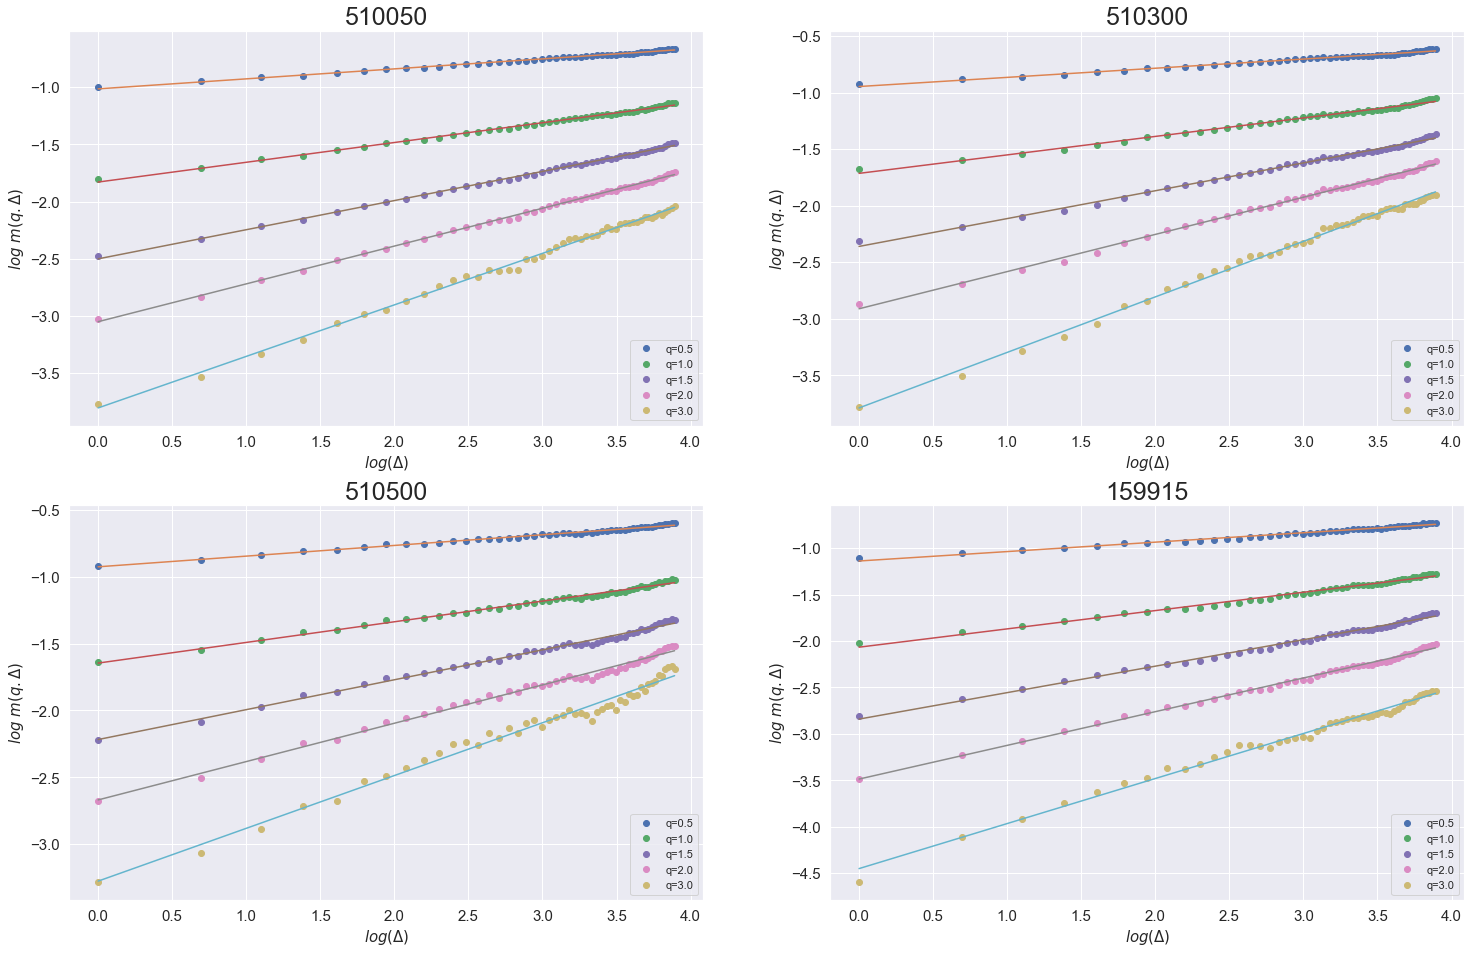

In [82]:
# 以lag为间隔 计算上述 m(2，delta)
def del_Raw(q, x, csd_symbol):
    return [np.mean(np.abs(globals()[f'min_hv_{csd_symbol}']['log_sqrt'] - globals()[f'min_hv_{csd_symbol}']['log_sqrt'].shift(lag)) ** q)
            for lag in x]

fig = plt.figure(figsize=(25,16))

for i, csd_symbol in enumerate(symbol_list):
    globals()[f'min_hv_{csd_symbol}']['sqrt']= globals()[f'min_hv_{csd_symbol}']['min_hv']
    globals()[f'min_hv_{csd_symbol}']['log_sqrt'] = np.log(globals()[f'min_hv_{csd_symbol}']['sqrt'])
    ax = fig.add_subplot(2,2,i+1)
    plt.xlabel('$log(\Delta)$',fontsize=15)
    plt.ylabel('$log\  m(q.\Delta)$',fontsize=15)
    plt.ylim=(-3, -.5)
    plt.title(csd_symbol,fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    zeta_q = list()
    qVec = np.array([.5, 1, 1.5, 2, 3])
    x = np.arange(1, 50)
    # print(globals()[f'min_hv_{csd_symbol}'].head())
    # print(np.log(del_Raw(q, x, csd_symbol)))
    for q in qVec:
        plt.plot(np.log(x), np.log(del_Raw(q, x, csd_symbol)), 'o', label=f'q={q}') 
        model = np.polyfit(np.log(x), np.log(del_Raw(q, x, csd_symbol)), 1)
        plt.plot(np.log(x), np.log(x) * model[0] + model[1])
        zeta_q.append(model[0])
    plt.legend()
plt.savefig('md/pic/国内期权类似检验.png', dpi=300)

0.1622585407306034
0.16524586876293884
0.13774281080329573
0.17440884099691925


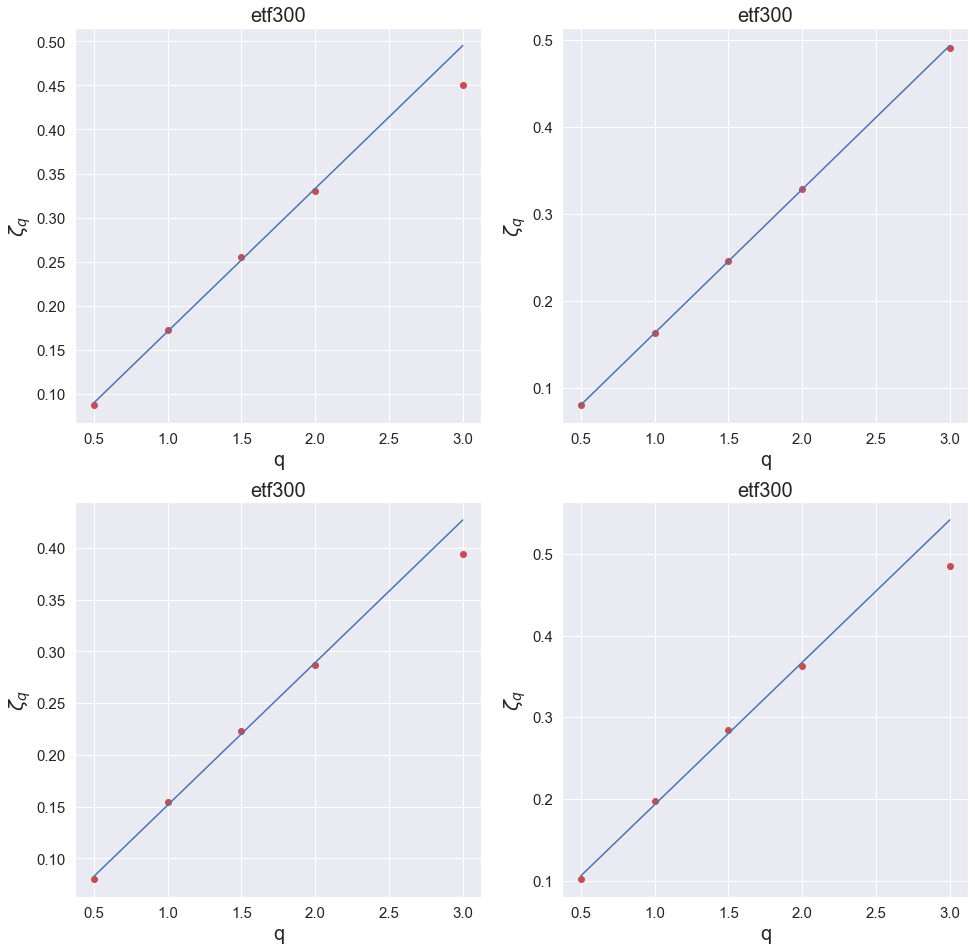

In [80]:
fig = plt.figure(figsize=(16,16))
for i, csd_symbol in enumerate(symbol_list):
    zeta_q = list()
    qVec = np.array([.5, 1, 1.5, 2, 3])
    x = np.arange(1, 50)
    for q in qVec:
        model = np.polyfit(np.log(x), np.log(del_Raw(q, x, csd_symbol)), 1)
        zeta_q.append(model[0])
    ax = fig.add_subplot(2,2,i+1)
    plt.xlabel('q', fontsize=20)
    plt.ylabel('$\zeta_{q}$', fontsize=20)
    plt.plot(qVec, zeta_q, 'or')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    line = np.polyfit(qVec[:4], zeta_q[:4],1)
    plt.plot(qVec, line[0] * qVec + line[1])
    plt.title('etf300', fontsize=20)
    h_est= line[0]
    print(h_est)
plt.savefig('md/pic/国内期权连线.png')

In [107]:
OxfordH = {'510050': 0.1622585407306034,
           '510300': 0.16524586876293884,
           '510500': 0.13774281080329573,
           '159915': 0.17440884099691925
           }
def plotScaling(csd_symbol, scaleFactor):#j表示选择哪一只期权， scaleFactor=5 即最后考虑的lag为sclafactor的0,1,2,3次方
    v = globals()[f'min_hv_{csd_symbol}']['min_hv']# 波动率数据
    x = np.arange(1,101)
    # xDel 计算x以lag为间隔的元素之差
    def xDel(x, lag):
        return x-x.shift(lag)
    # sdl 计算 log(sigma_{t+delta})-log(sigma_t) 这一序列的标准差
    def sdl(lag):
        return (xDel(np.log(v), lag)).std()
    sd1 = (xDel(np.log(v), 1)).std()
    # h为之前估计的对应期权的 H
    h = OxfordH[csd_symbol]
    f, ax = plt.subplots(2,2,sharex=False, sharey=False, figsize=(20, 15))
    for i_0 in range(0, 2):
        for i_1 in range(0, 2):
            la = scaleFactor ** (i_1*1+i_0*2)
            # hist_val 为已实现波动率的log(sigma_{t+delta})-log(sigma_t)
            hist_val = xDel(np.log(v), la).dropna()
            std = hist_val.std()
            mean = hist_val.mean()
            #bin为考虑的x轴点
            #绿色和橙色
            #红色为hist_val 均值标准差对应的正态分布曲线
            #蓝色为零均值，标准差为一天为间隔的标准差乘以考虑间隔的H次方，对应的正态分布曲线
            ax[i_0][i_1].set_title('Lag = %s Days' %la, fontsize=20)
            n, bins, patches = ax[i_0][i_1].hist(hist_val.values, bins=100,range=(-3,3),
                                   density=True,facecolor='green',alpha=0.2)#normed=1
            ax[i_0][i_1].plot(bins, norm.pdf(bins,mean,std), "b--")#红色
            # ax[i_0][i_1].plot(bins, norm.pdf(bins,0,sd1 * la ** h), "b--")
            hist_val.plot(kind='density', ax=ax[i_0][i_1])
            ax[i_0][i_1].legend(loc='best')
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.savefig(f'md/pic/{csd_symbol}_5天分布.png')
    return hist_val

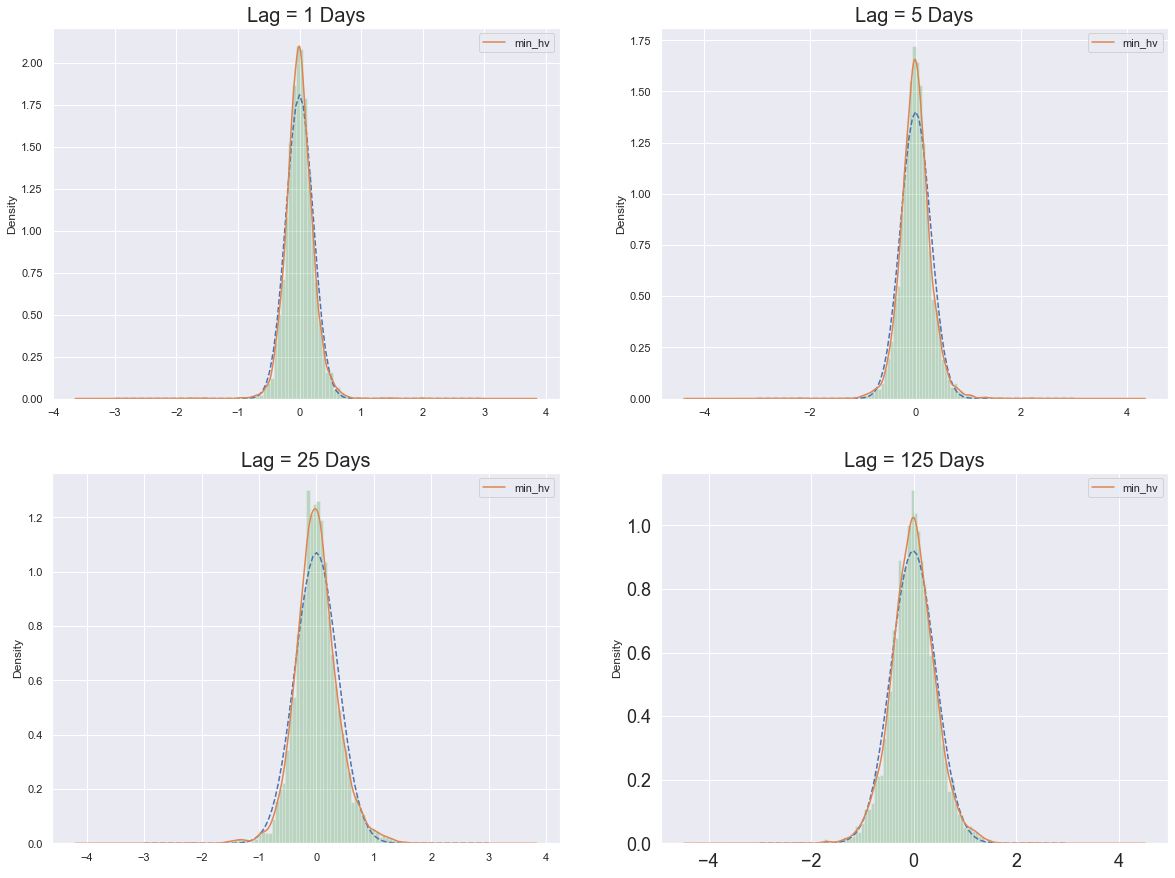

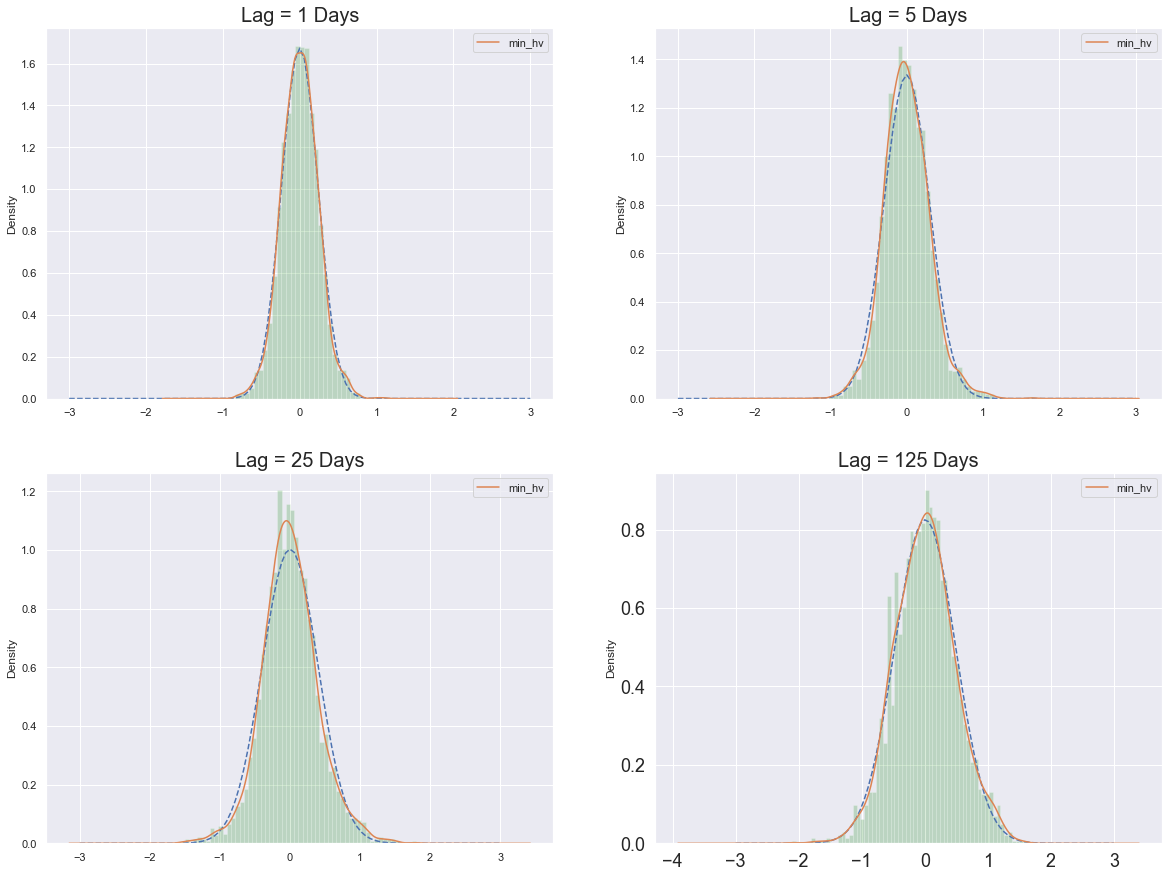

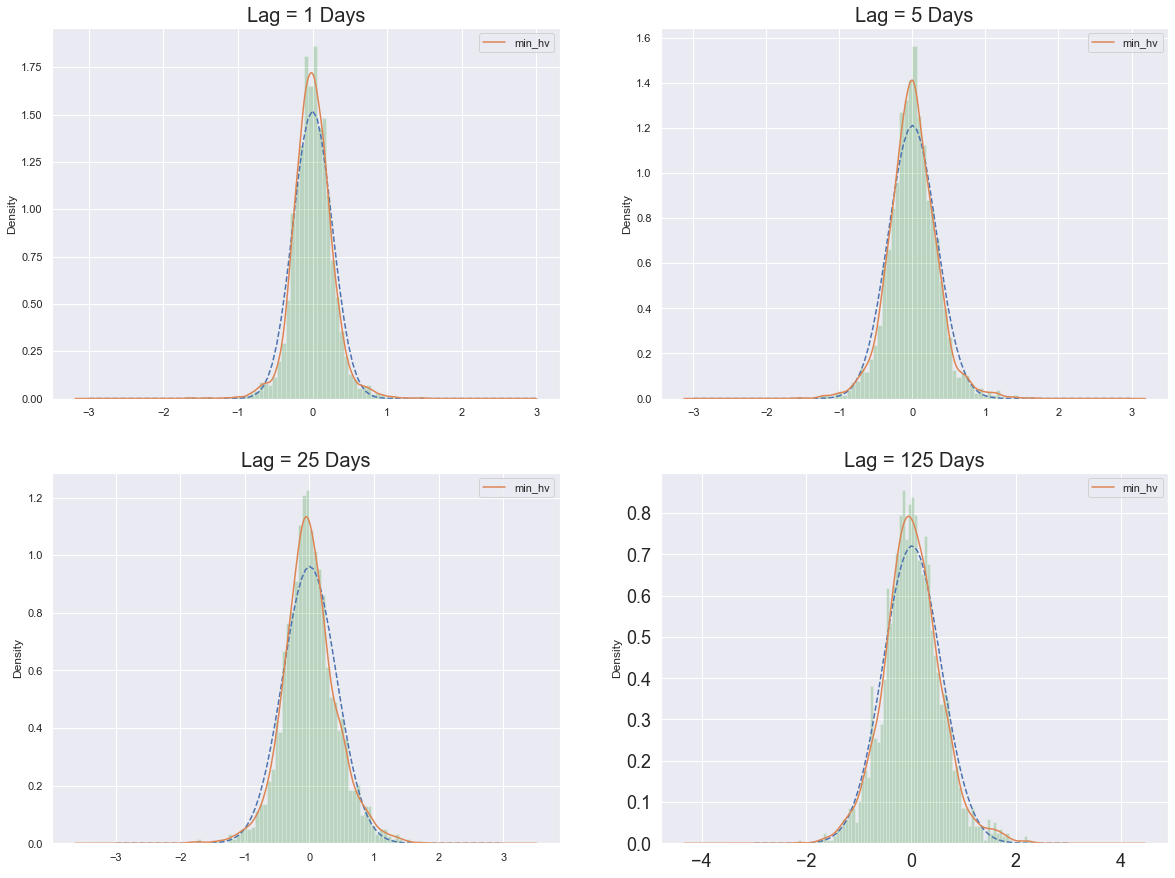

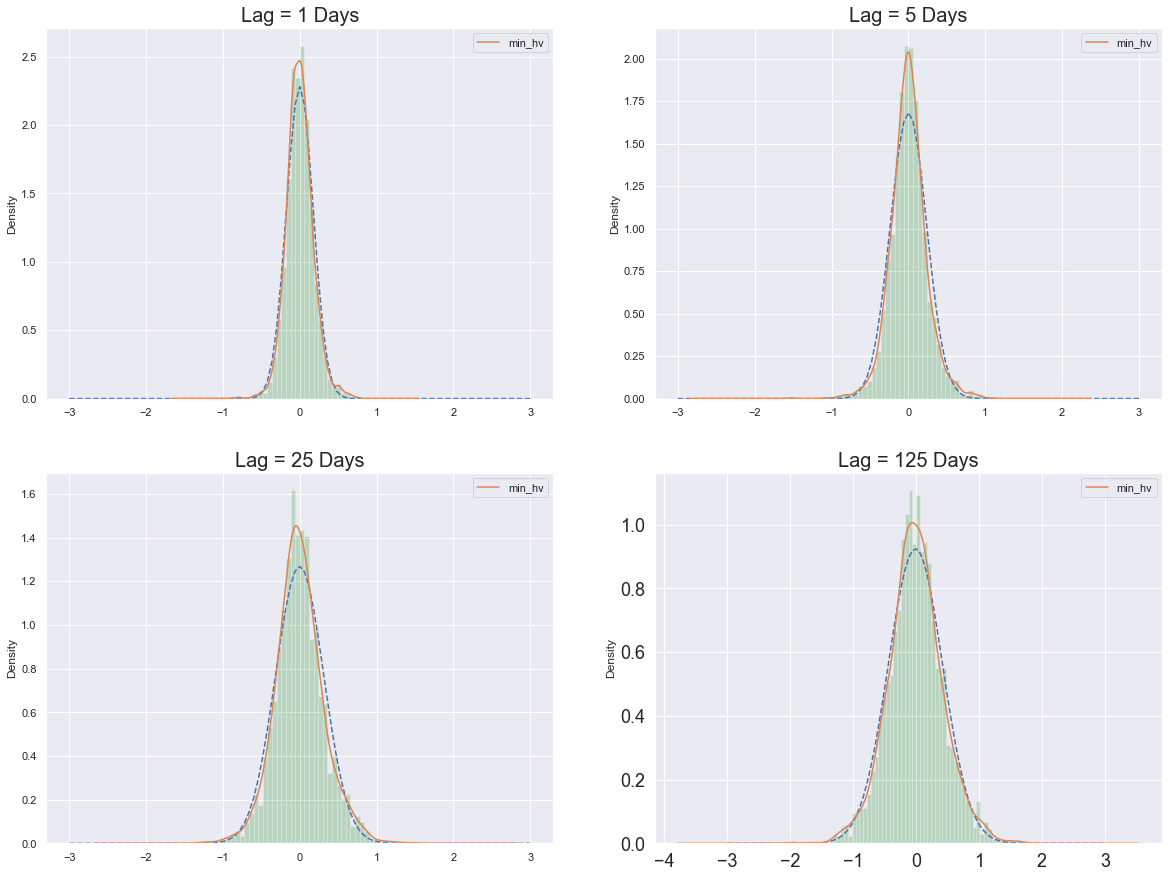

In [109]:
for csd_symbol in symbol_list:
    globals()[f'hist_{csd_symbol}'] = plotScaling(csd_symbol,5)

### 正态性检验

In [113]:
from scipy import stats

def xDel(x, lag):
        return x-x.shift(lag)

for csd_symbol in symbol_list:
    result = stats.kstest(np.array(globals()[f'hist_{csd_symbol}']), 'norm', (globals()[f'hist_{csd_symbol}'].mean(), globals()[f'hist_{csd_symbol}'].std()))
    print(result)
    res = []
    for lag in range(121):
            hist_val = xDel(np.log(globals()[f'min_hv_{csd_symbol}']['min_hv']), lag).dropna()
            result = stats.kstest(np.array(hist_val), 'norm', (hist_val.mean(), hist_val.std()))
            res += [result[1]]
    print(csd_symbol)
    print(np.array(res)<0.05)

KstestResult(statistic=0.022469951211363304, pvalue=0.02915989448611145)
510050
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True False False  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True]
KstestResult(statistic=0.015789429234564056, pvalue=0.5802859623014862)
510300
[False False False  True False False  True  True  True  True  True  True
  True  True  True  True  True